# <center>Предсказание цены продажи подержаного автомобиля</center>
## Знакомство с данными

In [25]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import category_encoders as ce

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pio.renderers.default = 'png'
plt.style.use('dark_background')

In [23]:
RANDOM_STATE = 42
N_JOBS = -1

In [4]:
original_data = pd.read_csv('data/CAR DETAILS FROM CAR DEKHO.csv')
data = original_data.copy()
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [7]:
data.describe(include='object').T

,count,unique,top,freq
name,4340,1491,Maruti Swift Dzire VDI,69
fuel,4340,5,Diesel,2153
seller_type,4340,3,Individual,3244
transmission,4340,2,Manual,3892
owner,4340,5,First Owner,2832


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,4340.0,2013.090783,4.215344,1992.0,2011.00,2014.0,2016.0,2020.0
selling_price,4340.0,504127.311751,578548.736139,20000.0,208749.75,350000.0,600000.0,8900000.0
km_driven,4340.0,66215.777419,46644.102194,1.0,35000.00,60000.0,90000.0,806599.0


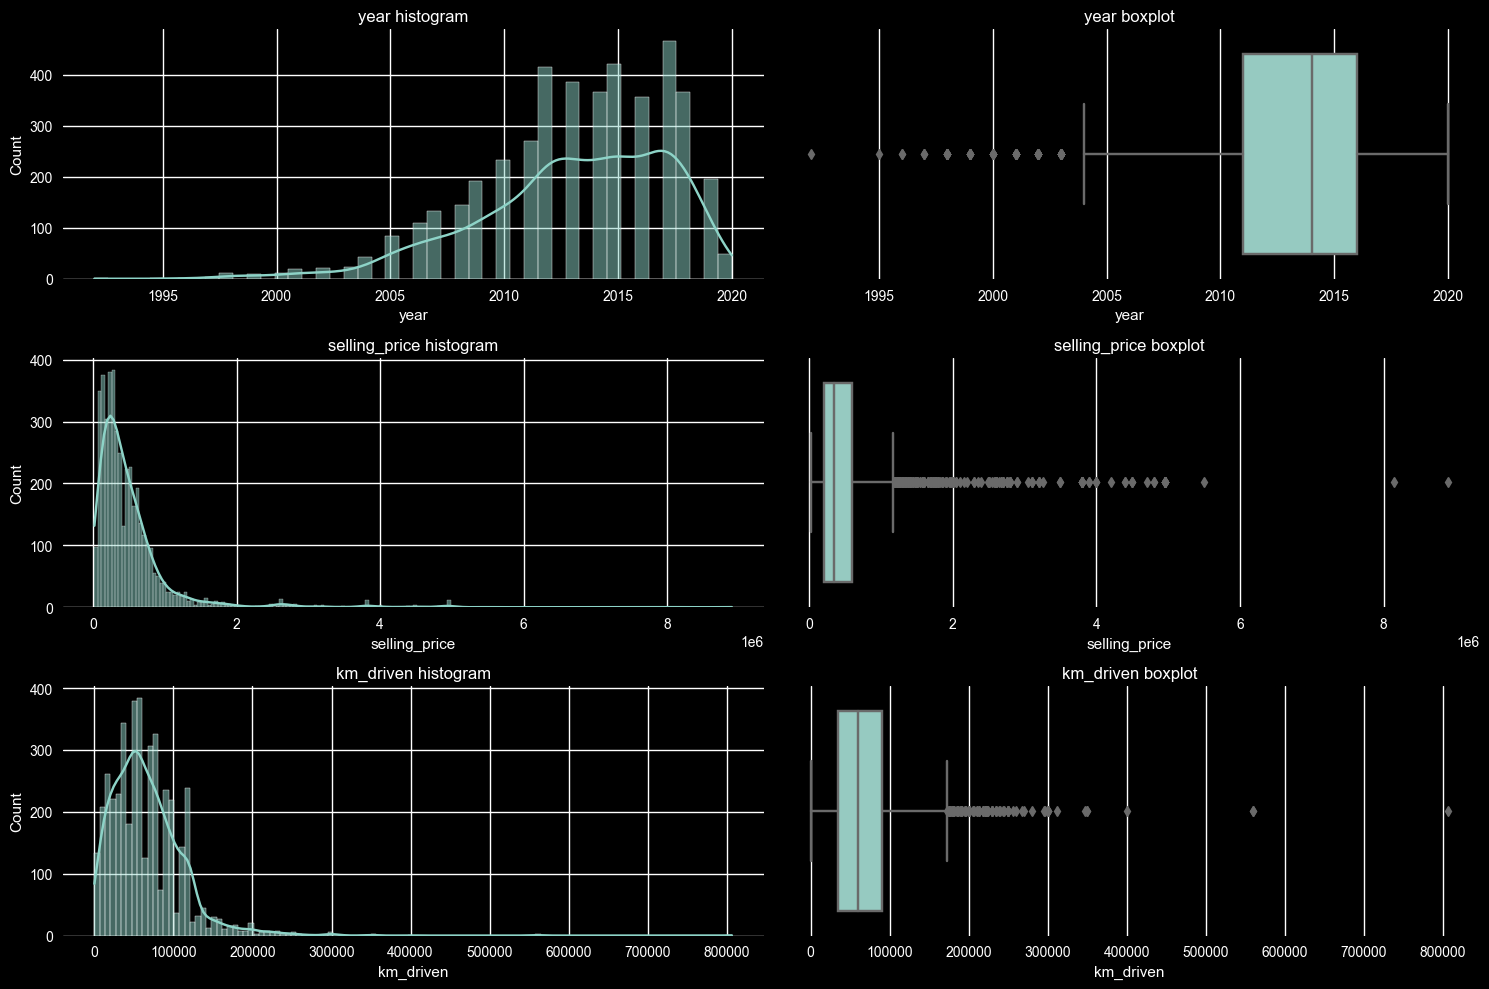

In [11]:
def make_histbox(data, features:list):
    fig, axs = plt.subplots(len(features), 2, figsize=(15, 10))
    for feature, row in zip(features, range(len(features))):
        ax, ay = axs[row, 0], axs[row, 1]
        sns.histplot(data, x=feature, ax=ax, kde=True)
        sns.boxplot(data, x=feature, ax=ay)
        ax.set_title(feature + ' histogram')
        ay.set_title(feature + ' boxplot')
    fig.tight_layout()
num_cols = [col for col in data.columns if data[col].dtype != 'object']
make_histbox(data, num_cols)

# Предобработка данных

In [12]:
data['name'].sample(20)

2331              Mahindra KUV 100 mFALCON G80 K2
528                          Hyundai Verna 1.6 SX
624                             Hyundai Santro GS
2843                        Honda Amaze VX i-VTEC
2927    Tata Indica Vista Aura 1.3 Quadrajet BSIV
4038                          Chevrolet Spark 1.0
1280                            Honda Jazz VX CVT
1965                         Hyundai Verna 1.4 EX
1358                      Maruti Zen LXi - BS III
3456                       Maruti Baleno Zeta 1.2
1461           Skoda Laura Ambiente 2.0 TDI CR MT
2324                   Honda Amaze VX Diesel BSIV
4153            Skoda Octavia Ambiente 1.9 TDI MT
833                     Ford Figo Petrol Titanium
2297                             Datsun GO Plus T
2807             Hyundai i20 Asta Option 1.4 CRDi
667                        Mahindra Thar CRDe ABS
2881                        Hyundai i20 1.2 Magna
1174                     Maruti Wagon R LXI Minor
3583                     Maruti Wagon R LXI BS IV


In [14]:
data['car_manufacturer'] = data['name'].apply(lambda name: name.split()[0])
data.drop(columns='name', inplace=True)
data.sample(10)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,car_manufacturer
279,2013,550000,29000,Diesel,Individual,Manual,First Owner,Hyundai
1601,2012,130000,120000,Diesel,Individual,Manual,First Owner,Tata
2375,2013,380000,100000,Diesel,Individual,Manual,First Owner,Tata
62,2014,675000,90000,Diesel,Dealer,Manual,First Owner,Honda
2852,2018,700000,27000,Petrol,Individual,Manual,First Owner,Hyundai
3056,2010,260000,50000,Petrol,Individual,Manual,First Owner,Maruti
969,2017,1900000,20000,Petrol,Individual,Automatic,First Owner,Toyota
1283,2006,78000,64700,Petrol,Individual,Manual,First Owner,Maruti
923,2016,670000,7104,Petrol,Trustmark Dealer,Manual,First Owner,Maruti
3121,2014,425000,40000,Petrol,Individual,Manual,First Owner,Volkswagen


In [15]:
data['car_manufacturer'].describe()

count       4340
unique        29
top       Maruti
freq        1280
Name: car_manufacturer, dtype: object

## Визуализация зависимостей в данных

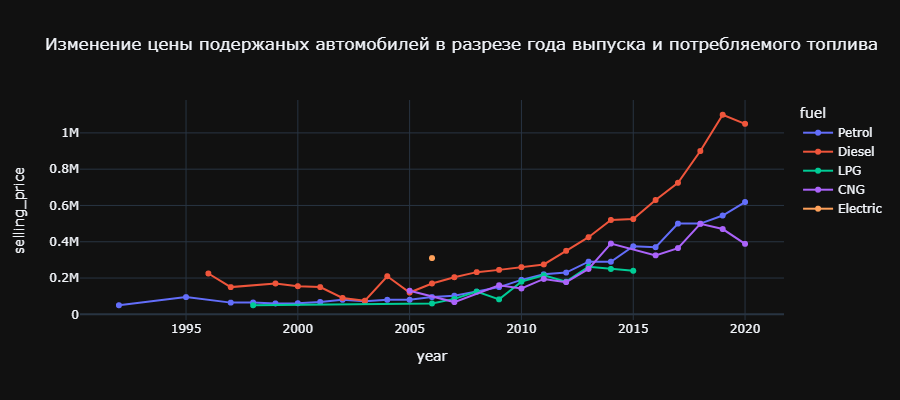

In [16]:
grouped_by_year = data.groupby(['year', 'fuel'], as_index=False)[['selling_price']].median()
px.line(
    grouped_by_year,
    x='year',
    y='selling_price',
    color='fuel',
    width=900,
    height=400,
    markers=True,
    title='Изменение цены подержаных автомобилей в разрезе года выпуска и потребляемого топлива',
    template='plotly_dark'
).show()

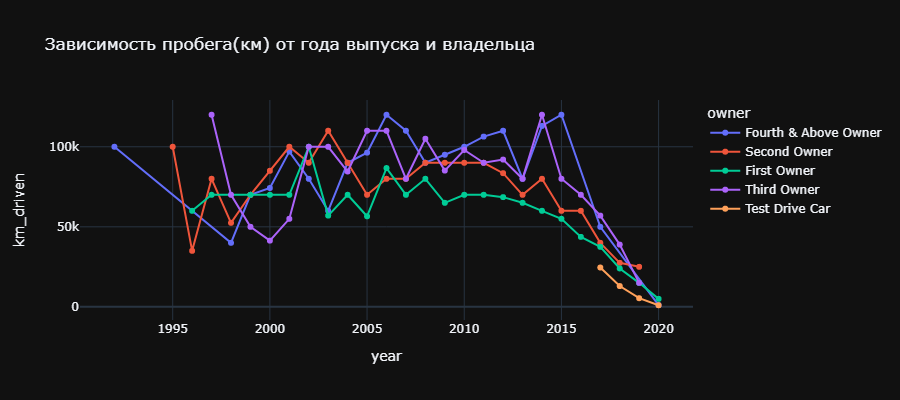

In [17]:
grouped_by_owner = data.groupby(['year', 'owner'], as_index=False)['km_driven'].median()
px.line(
    grouped_by_owner,
    x='year',
    y='km_driven',
    color='owner',
    width=900,
    height=400,
    markers=True,
    title='Зависимость пробега(км) от года выпуска и владельца',
    template='plotly_dark'
).show()

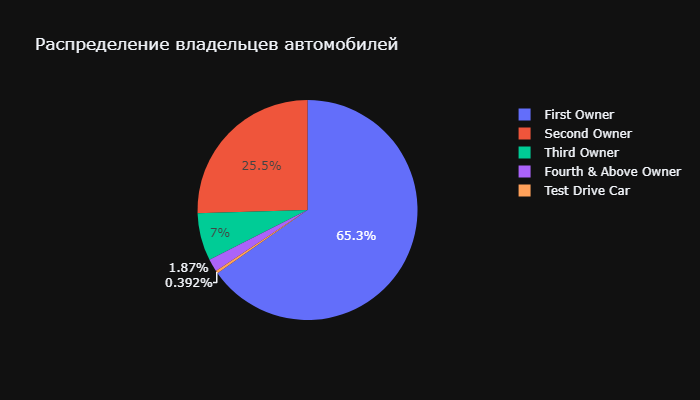

In [18]:
px.pie(
    data,
    names='owner',
    width=700,
    height=400,
    title='Распределение владельцев автомобилей',
    template='plotly_dark'
)

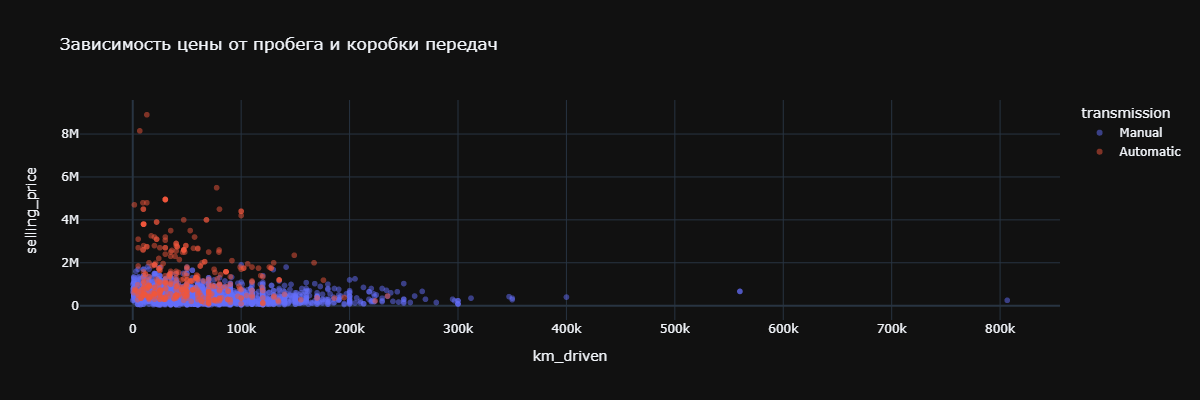

In [19]:
px.scatter(
    data,
    x='km_driven',
    y='selling_price',
    opacity=0.5,
    color='transmission',
    title='Зависимость цены от пробега и коробки передач',
    height=400,
    width=1200,
    template='plotly_dark'
)

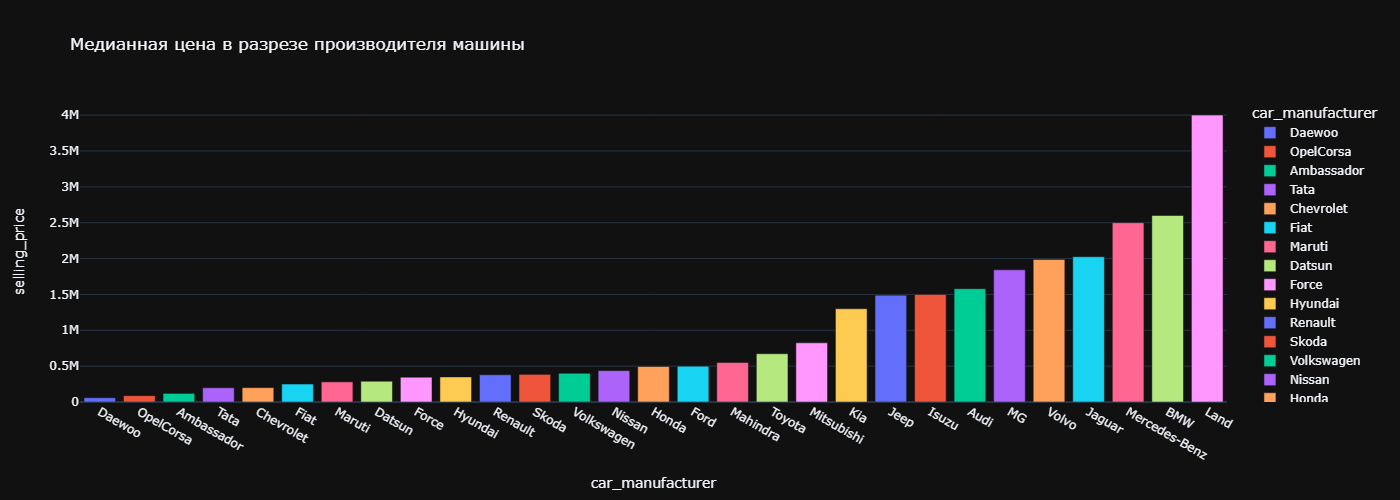

In [20]:
grouped_by_manufact = data.groupby(['car_manufacturer'], as_index=False)['selling_price'].median().sort_values(by='selling_price')
px.bar(
    grouped_by_manufact,
    x='car_manufacturer',
    y='selling_price',
    color='car_manufacturer',
    width=1400,
    height=500,
    title='Медианная цена в разрезе производителя машины',
    template='plotly_dark'
)

## EDA

In [21]:
data.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,car_manufacturer
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,Hyundai
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,Datsun
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,Honda


In [24]:
X, y = data.drop(columns='selling_price'), data['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3038, 7) (1302, 7) (3038,) (1302,)


In [ ]:
oh_encoder = preprocessing.OneHotEncoder()
bin_encoder = preprocessing.LabelBinarizer()
ord_encoder = preprocessing.OrdinalEncoder()

oh_cols = ['fuel', 'seller_type', 'owner']
bin_cols = ['car_manufacturer']
ord_cols = ['transmission']
numeric_cols = ['year', 'km_driven']

oh_encoded = oh_encoder.fit_transform(data[['fuel', 'seller_type', 'owner']])
bin_encoded = bin_encoder.fit_transform(data['car_manufacturer'])
data['transmission'] = data['transmission'].apply(lambda trans: int('Manual' in trans))
num_cols.append('transmission')
encoded_cats = pd.concat([oh_encoded, bin_encoded], axis=1)
encoded_data = pd.concat([data[num_cols], encoded_cats], axis=1)
encoded_data.head()

In [ ]:
fig, ax = plt.subplots(2, figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask_num = np.triu(np.ones_like(data[num_cols].corr()))
mask_cat = np.triu(np.ones_like(encoded_cats.corr(method='spearman')))
sns.heatmap(data[num_cols].corr(), annot=True, ax=ax[0], cmap=cmap, mask=mask_num)
sns.heatmap(encoded_cats.corr(method='spearman'), annot=True, ax=ax[1], cmap=cmap, mask=mask_cat)
ax[0].set_title('Корреляция Пирсона для числовых признаков')
ax[1].set_title('Корреляция Спирмана для категориальных признаков');

In [ ]:
drop_cols = ['fuel_Diesel', 'seller_type_Dealer']
encoded_data.drop(columns=drop_cols, inplace=True)
encoded_data.info()

## Создание модели линейной регрессии

In [ ]:
# Разбиваем выборку на трейн и тест
X, y = encoded_data.drop(columns='selling_price'), encoded_data['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_test.shape)

In [ ]:
# Обучаем модель на данных
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, np.log(y_train))

# Делаем предсказания
y_train_predict = np.exp(lr_model.predict(X_train))
y_test_predict = np.exp(lr_model.predict(X_test))

# Рассчитываем метрики
print('Train:')
print('MAPE:', metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100)
print('R2:', metrics.r2_score(y_train, y_train_predict))
print()
print('Test:')
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100)
print('R2:', metrics.r2_score(y_test, y_test_predict))

In [ ]:
lr_model.coef_

У модели слишком большое смещение, попробуем его уменьшить, добавив полиномиальные признаки 2-й степени, а чтобы избежать переобучения, используем регуляризацию.

In [ ]:
# Нормализуем данные перед созданием полиномиальных признаков
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)
# Создадим полиномиальные признаки
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)

In [ ]:
# Найдем оптимальное значение alpha для L1 и L2, а затем сравним их
alpha_list = np.linspace(1e-3, 20, 50)
train_score_lasso, test_score_lasso = [], []
train_score_ridge, test_score_ridge = [], []
for alpha in alpha_list:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=10000)
    ridge = linear_model.Ridge(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled_poly, np.log(y_train))
    ridge.fit(X_train_scaled_poly, np.log(y_train))
    
    y_train_lasso, y_test_lasso = lasso.predict(X_train_scaled_poly), lasso.predict(X_test_scaled_poly)
    y_train_ridge, y_test_ridge = ridge.predict(X_train_scaled_poly), ridge.predict(X_test_scaled_poly)
    
    train_score_lasso.append(metrics.r2_score(y_train, np.exp(y_train_lasso)))
    test_score_lasso.append(metrics.r2_score(y_test, np.exp(y_test_lasso)))
    train_score_ridge.append(metrics.r2_score(y_train, np.exp(y_train_ridge)))
    test_score_ridge.append(metrics.r2_score(y_test, np.exp(y_test_ridge)))
    
fig, axes = plt.subplots(2, figsize=(15, 15))
sns.lineplot(
    x=alpha_list,
    y=train_score_lasso,
    label='Train Lasso',
    ax=axes[0]
)
sns.lineplot(
    x=alpha_list,
    y=test_score_lasso,
    label='Test Lasso',
    ax=axes[0]
)
sns.lineplot(
    x=alpha_list,
    y=train_score_ridge,
    label='Train Ridge',
    ax=axes[1]
)
sns.lineplot(
    x=alpha_list,
    y=test_score_ridge,
    label='Test Ridge',
    ax=axes[1]
)
axes[0].set_xticks(alpha_list)
axes[0].xaxis.set_tick_params(rotation=45)
axes[1].set_xticks(alpha_list)
axes[1].xaxis.set_tick_params(rotation=45)
axes[0].set_title('Lasso')
axes[1].set_title('Rigde')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('R2')
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('R2');